(ch:getting_started_with_neural_networks)=
# 신경망 활용 처음부터 끝까지: 분류와 회귀

**감사의 글**

아래 내용은 프랑소와 숄레의 
[Deep Learning with Python(2판)](https://github.com/fchollet/deep-learning-with-python-notebooks)의 
소스코드 내용을 참고해서 작성되었습니다.
자료를 공개한 저자에게 진심어린 감사를 전합니다.

**소스코드**

여기서 언급되는 코드를
[(구글 코랩) 신경망 활용 처음부터 끝까지: 분류와 회귀](https://colab.research.google.com/github/codingalzi/dlp2/blob/master/notebooks/NB-getting_started_with_neural_networks.ipynb)에서 
직접 실행할 수 있다.

**주요 내용**

간단한 실전 예제을 이용하여 신경망 모델을 
이진 분류, 다중 클래스 분류, 회귀 문제에 적용하는 방법을 소개한다.

- 이진 분류: 영화 후기 분류
- 다중 클래스 분류: 뉴스 기사 분류
- 회귀: 주택 가격 예측

이를 통해 데이터 전처리, 모델 구조 설계, 모델 평가의 딥러닝 모델 훈련의
전체 과정을 자세히 살펴본다.

**머신러닝 주요 용어**

아래 용어의 정의를 명확히 알아야 한다.

| 한글 | 영어 | 뜻 |
| :--- | :--- | :--- |
| 샘플, 입력값 | sample, input | 모델 훈련에 사용되는 데이터 |
| 예측값, 출력값 | prediction, output | 모델이 계산한 결과 |
| 타깃 | target | 예측해야 하는 값 |
| 예측 오류, 손실값, 비용 | prediction error, loss value | 타깃과 예측값 사이의 거리 측정값. 측정 방식에 의존함.|
| 손실 함수, 비용 함수| loss function | 손실값(비용)을 계산하는 함수 |
| 클래스 | class | 분류 문제에서 샘플이 속하는 범주 |
| 레이블 | label | 분류 문제에서 타깃 대신 사용 |
| 실제의/정답의 | ground-truth | 실제 조사 결과와 관련된 |
| 이진 분류 | binary classification | 샘플을 두 개의 클래스로 분류. 양성/음성, 긍정/부정 등. |
| 다중 클래스 분류 | multiclass classification | 샘플을 세 개 이상의 클래스로 분류. 손글씨 숫자 등. |
| 다중 레이블 분류 | multilabel classification | 샘플에 두 종류 이상의 레이블을 지정하는 분류.사진 속 여러 마리 동물 등. |
| 스칼라 회귀 | scalar regression | 샘플 별로 하나의 실숫값 예측하기. 주택 가격 예측 등. |
| 벡터 회귀 | vector regression | 샘플 별로 두 개 이상의 실숫값 예측하기. 네모 상자의 좌표 등. |
| 미니배치 | mini-batch | 보통 8개에서 128개의 샘플로 구성된 묶음(배치). 훈련 루프의 스텝 지정에 활용됨. |

## 영화 후기: 이진 분류

영화 후기가 긍정적인지 부정적인지를 판단하는 이진 분류 모델을 구성한다.

**IMDB 데이터셋**

긍정 후기와 부정 후기 각각 25,000개씩 총 50,000개의 영화 후기 샘플로 구성된 데이터셋이며,
[IMDB(Internet Moview Database)](https://www.imdb.com/) 영화 후기 사이트에서
추출된 데이터로 케라스가 자체적으로 제공한다. 

케라스의 `imdb` 모듈의 `load_data()` 함수로 데이터를 불러온다.
데이터셋이 훈련셋과 테스트셋으로 이미 구분되어 있다.

```python
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
```

`num_words=10000` 키워드 인자는
가장 많이 사용되는 10,000개의 단어로만 구성된 후기를 불러오도록 지정한다.
10,000개의 단어에 포함되지 않는 단어는 무시한다.

후기 전체에서 원래 총 88,585개의 단어가 최소 한 번 이상 사용되지만 가장 많이 사용되는
10,000개 단어 이외는 사용 빈도가 너무 낮아서 클래스 분류에 거의 도움되지 않는다.
따라서 그런 단어들은 무시하는 것이 좋다.

샘플들의 크기는 서로 다르다.

```python
>>> len(train_data[0])
218
>>> len(train_data[1])
189
```

0번 샘플의 처음 10개 값은 다음과 같다.

```python
>>> train_data[0][:10]
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
```

각 샘플의 레이블은 0(부정) 또는 1(긍정)이다.

```python
>>> train_labels[0]
1
>>> test_labels[0]
0
```

:::{admonition} 영화 후기 내용
:class: tip

**모델 훈련을 위해 반드시 필요한 사항은 아니지만**
정수와 단어 사이의 관계를 담은 사전을 이용하여
원하면 후기 내용을 확인할 수 있다.

```python
>>> word_index = imdb.get_word_index()
```

`word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

```python
>>> list(word_index.items()[:10]
('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)
('woods', 1408)
('spiders', 16115)
('hanging', 2345)
('woody', 2289)
('trawling', 52008)
```

아래 코드는 첫째 후기의 내용을 확인한다.
단어 인덱스에서 3을 빼야 함에 주의하라.
이유는 인덱스 0, 1, 2는 각각 여백, 문장 시작, 불분명을 의미하기 때문이다.
앞서 10,000개의 가장 많이 사용되는 단어만을 대상으로 하였기에
그 이외의 단어는 모두 2로 처리된다.

```python
>>> reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
>>> first_review = train_data[0]
>>> decoded_review = " ".join([reverse_word_index.get(i-3, "?") for i in first_review])
```

첫째 후기 내용은 다음과 같다.

```python
>>> decoded_review
"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"
```
:::

**데이터 전처리: 벡터화, 멀티-핫-인코딩**

정수들의 리스트, 그것도 길이가 다른 여러 개의 리스트를 신경망의 입력값으로 사용할 수 없다. 
따라서 각 샘플을 지정된 크기의 1차원 어레이로 변환하는 
**벡터화**<font size='2'>vectorization</font>를 먼저 실행해야 한다.

그런데 서로 길이가 다른 정수들의 리스트의 길이를 통일시킨다 하더라도 
정수들의 리스트를 직접 신경망 모델의 입력값으로 사용하는 일은 가급적 피한다.
여기서는 대신에 **멀티-핫-인코딩**을 이용하여 정수들의 리스트를
0과 1로만 이루어진 일정한 길이의 벡터(1차원 어레이)로 변환한다. 

후기 리스트에 사용된 숫자들은 0부터 9999 사이의 값이다.
이 정보를 이용하여 후기 샘플을 길이가 10,000인 벡터(1차원 어레이)로 변환할 수 있다.

- 어레이 길이: 10,000
- 항목: 0 또는 1
- 후기 샘플에 포함된 정수에 해당하는 인덱스의 항목만 1로 지정

예를 들어, `[1, 18, 13]`은 길이가 10,000인 1차원 어레이(벡터)로 변환되는데
1번, 18번, 13번 인덱스의 항목만 1이고 나머지는 0으로 채워진다.
이러한 변환을 **멀티-핫-인코딩**<font size='2'>multi-hot-encoding</font>이라 부른다.

아래 `vectorize_sequences()` 함수는 앞서 설명한 멀티-핫-인코딩을 
모든 주어진 샘플에 대해 실행하여 최종적으로
데이터셋을 표현하는 넘파이 어레이를 반환한다.

```python
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):    # 모든 샘플에 대한 멀티-핫-인코딩
        for j in sequence:
            results[i, j] = 1.
    return results
```

:::{prf:example} 훈련셋 벡터화
:label: exp-vectorization

이제 훈련셋와 테스트셋를 벡터화한다.
자료형은 `float32`로 고정한다. 그렇지 않으면 `float64`로 지정되기에
메모리 효율성을 떨어뜨린다.

```python
>>> x_train = vectorize_sequences(train_data).astype("float32")
>>> x_test = vectorize_sequences(test_data).astype("float32")
```

첫째 훈련 샘플의 변환 결과는 다음과 같다.

```python
>>> x_train[0]
array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)
```

레이블 또한 정수 자료형에서 `float32` 자료형으로 변환해서 자료형을 일치시킨다.

```python
>>> y_train = np.asarray(train_labels).astype("float32")
>>> y_train
array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)
```
:::

**모델 구성**

입력 샘플의 특성이 벡터(1차원 어레이)로 주어지고 
레이블이 스칼라(하나의 숫자)로 주어졌을 때 
밀집층<font size='2'>densely-connected layer</font>인 `Dense` 층을 이용하는
`Sequential` 모델을 추천한다.
이때 사용하는 활성화 함수는 일반적으로 다음과 같다.

- 은닉층의 활성화 함수: 음수를 제거하는 `relu()` 함수
- 이진 분류 모델의 최상위 층의 활성화 함수: 0과 1사이의 확률값을 계삲하는 `sigmoid()` 함수

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp/master/slides/images/relu_sigmoid.png" style="width:600px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

`Dense` 층을 이용할 때의 핵심은 두 가지다.

- 몇 개의 층을 사용하는가?
- 각 층마다 몇 개의 유닛<font size='2'>unit</unit>을 사용하는가?

위 두 질문에 대한 체계적인 답은
{numref}`%s장 머신러닝 핵심 이슈<ch:fundamentals_of_ml>`에서 다룬다.
여기서는 일단 아래 구성을 사용한다.

- 두 개의 연속된 밀집층
- 각각 16개의 유닛

```python
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
```

`Dense` 층의 유닛이 많을 수록 입력값에 내재된 보다 많은 특성을 찾아내어 보다 복잡한
모델을 학습한다. 하지만 유닛수가 많을 수록 모델 훈련에 필요한 비용(시간과 메모리)이
늘어난다.

:::{admonition} `relu()` 활성화 함수
:class: hint

마지막 층을 제외한 모든 층에서 `relu()` 활성화 함수를 사용한다.
이유는 그렇게 하지 않으면 기본적으로 선형 분류 모델이 생성되기 때문이며
비선형 분류 문제는 해결하지 못하기 때문이다.

`relu()`, `prelu()`, `elu()`, `tanh()` 등 다양한 종류의 활성화 함수가 경우에 따라 사용된다.
하지만 여기서는 기본적으로 `relu()`를 사용한다.
:::

위 모델을 시각화하면 다음과 같다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/04-01.png" style="width:200px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

:::{admonition} 사이킷런의 로지스틱 회귀 모델
:class: info

이진 분류 모델의 최상위 층은 스칼라 값을 출력하도록 하나의 유닛을 사용하는 
`Dense` 밀집층을 사용한다. 
또한 활성화 함수로 0과 1사이의 확률값을 계산하는 `sigmoid()`를 활성화 함수로 사용한다.
그러면 [사이킷런의 로지스틱 회귀<font size='2'>logistic regression</font> 모델](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)처럼 작동한다.
:::

**모델 컴파일**

모델을 훈련시키기 전에 컴파일한다. 
사용되는 옵티마이저, 손실 함수, 평가지표는 다음과 같다.

- `optimizer="rmsprop"`: 일반적으로 추천되는 옵티마이저.
- `loss="binary_crossentropy"`: 이진 분류 모델에서 확률 결과에 대한 오차 계산 용도로 최선임. 
    로그 손실이라고도 불림.
- `metrics="accuracy"`: 정확도가 분류 모델의 기본적인 평가지표로 사용됨.

```python
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
```

**모델 훈련**

훈련 중인 모델을 에포크마다 검증하기 위해 검증셋을 따로 지정한다.
여기서는 10,000개의 샘플을 검증셋으로 활용한다.

```python
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
```

**`History` 객체 활용**

`fit()` 메서드가 반환하는 객체는 `Callback` 클래스를 상속하는
`History` 클래스의 객체이며 모델 훈련과정 중에 계산되는 다양한 정보를 저장한다.
콜백(`Callback`) 클래스에 대해서는 {numref}`%s장 <ch:working_with_keras>`에서 자세히 살펴본다.

`History` 객체의 속성 중에서 `history` 속성이 가장 많이 활용된다.
`history` 속성은 훈련중 에포크 단위로 측정된 손실값과 평가지표를 사전으로 저장한다.

```python
>>> history_dict = history.history
>>> history_dict.keys()
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
```

예를 들어, `history` 속성에 저장된 정보를 이용하여 
훈련셋과 검증셋에 대한 에포크별 손실값과 정확도의 변화를 그래프로 그릴 수 있다.

*손실값의 변화*

훈련셋와 검증 세트에 대한 에포크별 손실값의 변화를 보면
훈련셋에 대해서는 손실값이 계속 감소하지만 
검증셋에 대해서는 9번째 에포크 전후 정체하다가 상승한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/04-04.png" style="width:500px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

*정확도의 변화*

훈련셋과 검증셋에 대한 에포크별 정확도의 경우엔
훈련셋에 대해서는 정확도 계속 증가한다.
반면에 검증셋에 대해서는 역시 9번째 에포크 전후 정체하다가 감소한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/04-05.png" style="width:500px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

**과대적합**

과대적합<font size='2'>overfitting</font>은 모델이 훈련셋에 익숙해진다는 의미이다.
반면에 처음 보는 데이터에 대해서는 성능이 떨어진다.
에포크가 진행될 수록 훈련셋에 대한 성능은 계속해서 좋아지지만
검증셋에 대한 성능이 4번째 에포크 이후에 오히려 나빠진다.

**모델 재훈련**

과대적합을 방지하기 위한 다양한 기법은 
{numref}`%s장 <ch:fundamentals_of_ml>`에서 다룬다.
위 문제의 경우 4번의 에포크만 훈련 반복을 진행하면 된다.

모델 구성부터, 컴파일, 훈련을 모두 다시 시작해야 
가중치와 편향이 초기화된 상태서 훈련을 시작한다.

```python
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
```

테스트셋에 대한 성능은 아래와 같이 88% 정도의 정확도를 보인다. 모델의 손실값은 0.31 정도.
앞으로 보다 좋은 성능의 모델을 살펴볼 것이며, 현존하는 가장 좋은 모델의 정확도는 95% 정도이다.

```python
>>> results = model.evaluate(x_test, y_test)
>>> results
[0.3139097988605499, 0.8770800232887268]
```

**모델 활용**

훈련된 모델을 활용하려면 `predict()` 메서드를 이용한다.
큰 데이터셋에 대해 미니배치 단위로 예측할 수 있다. 

- 0,99 이상 또는 0.01 이하의 경우: 매우 확실한 예측
- 0.4 ~ 0.6: 불확실한 예측

```python
>>> model.predict(x_test, batch_size=512)
array([[0.25440323],
       [0.9999424 ],
       [0.95840394],
       ...,
       [0.17153329],
       [0.10725482],
       [0.6672551 ]], dtype=float32)
```

## 뉴스 기사: 다중 클래스 분류

**로이터 데이터셋**

로이터<font size='2'>Reuter</font> 통신사가 1986년에 작성한 짧은 기사 모음집이다.
총 11,228개의 기사로 구성되었으며 훈련셋과 테스트셋으로 이미 구분되어 있다.

- 훈련셋 크기: 8,982
- 테스트셋 크기: 2,246

기사의 주제는 46개로 구분되며, 각각의 기사에 하나의 주제가 할당되어 있다.
여기서 훈련시키는 모델은 기사별로 46개 중의 하나의 주제를 예측해는
분류 모델이며, 클래스가 3개 이상이기에 
**다중 클래스 분류**<font size='2'>multiclass classification</font> 모델이라 부른다.

케라스의 `reuters` 모듈의 `load_data()` 함수로 데이터셋을 불러올 수 있다.
영화 후기의 경우처럼 사용 빈도가 상위 10,000등 이내의 단어만 사용하도록 한다.

```python
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
```

각 샘플은 정수들의 리스트이다.

```python
>>> train_data[10]
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979,
3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
```

각 샘플에 대한 레이블은 0부터 45까지의 정수로 표현된다.
예를 들어, 10번 기사의 주제는 3이다. 

```python
>>> train_labels[10]
3
```

:::{admonition} 로이터 기사 주제
:class: tip

기사 주제 3은 'earn'(수익)과 연관된다.
언급된 46개의 주제와 번호 사이의 관계는
[GitHub: Where can I find topics of reuters dataset #12072](https://github.com/keras-team/keras/issues/12072)에서 확인할 수 있다.

```
{'cocoa': 0,
'grain': 1,
'veg-oil': 2,
'earn': 3,
'acq': 4,
'wheat': 5,
'copper': 6,
'housing': 7,
'money-supply': 8,
'coffee': 9,
'sugar': 10,
'trade': 11,
'reserves': 12,
'ship': 13,
'cotton': 14,
'carcass': 15,
'crude': 16,
'nat-gas': 17,
'cpi': 18,
'money-fx': 19,
'interest': 20,
'gnp': 21,
'meal-feed': 22,
'alum': 23,
'oilseed': 24,
'gold': 25,
'tin': 26,
'strategic-metal': 27,
'livestock': 28,
'retail': 29,
'ipi': 30,
'iron-steel': 31,
'rubber': 32,
'heat': 33,
'jobs': 34,
'lei': 35,
'bop': 36,
'zinc': 37,
'orange': 38,
'pet-chem': 39,
'dlr': 40,
'gas': 41,
'silver': 42,
'wpi': 43,
'hog': 44,
'lead': 45}
```

실제로 10번 기사 내용을 확인해보면 'earn'과 관련되어 있어 보인다.
데이터를 해독(decoding)하는 방법은 IMDB 데이터셋의 경우와 동일하다.

```python
>>> word_index = reuters.get_word_index()
>>> reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
>>> decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[10]])
>>> decoded_newswire
'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'
```
:::

**데이터 전처리**

*입력 데이터셋 벡터화: 멀티-핫-인코딩*

IMDB의 경우와 동일하게 모든 샘플을 길이가 10,000인 벡터로 변환한다.

```python
>>> x_train = vectorize_sequences(train_data)
>>> x_test = vectorize_sequences(test_data)
```

*레이블 데이터셋 벡터화: 원-핫-인코딩*

레이블은 0부터 45 사이의 값이다.
이런 경우 정수로 구성된 텐서를 사용하기 보다는
**원-핫-인코딩**<font size='2'>one-hot-encoding</font>
기법을 적용하는 게 좋다.

원-핫-인코딩은 멀티-핫-인코딩 기법과 유사하다.
원-핫-인코딩으로 생성된 텐서는 한 곳만을 제외한 모든 항목이 0이다.
예를 들어, 정수 3은 길이가 46인 벡터로 변환되는데
3번 인덱스에서만 1이고 나머지 항목은 모두 0이다.

아래 함수는 정수들의 어레이로 주어진 레이블 데이터셋을
원-핫-인코딩된 원-핫-벡터로 구성된 2차원 텐서로 변환한다.
각 원-핫-벡터의 길이(차원)는 46이다.

```python
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
```

*`to_categorical()` 함수*

케라스의 `to_categorical()` 함수가 원-핫-인코딩을 지원한다.
원-핫-벡터의 길이는 사용된 레이블의 최댓값에 1을 더한 값이다.

```python
>>> from tensorflow.keras.utils import to_categorical
>>> y_train = to_categorical(train_labels)
>>> y_test = to_categorical(test_labels)
>>> y_train[0]
array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
```

:::{admonition} `CategoryEncoding` 층
:class: info

원-핫-인코딩, 멀티-핫-인코딩 등 정수를 사용하는 데이터를 범주형 데이터로 변환하는 
전처리 과정을 지원하는 층<font size='2'>layer</font>이 있다.
예를 들어 [tf.keras.layers.CategoryEncoding](https://keras.io/api/layers/preprocessing_layers/categorical/category_encoding/)은 
원-핫-인코딩과 멀티-핫-인코딩을 지원한다.
:::

**모델 구성**

IMDB 데이터셋의 경우와는 달리 3 개 이상의 클래스로 분류하는 
**다중 클래스 분류** 모델의 최종 층은 
분류해야 하는 클래스의 수 만큼의 유닛과 함께
각 클래스에 속할 확률을 계산하는 
`softmax` 활성화 함수를 이용한다.

:::{admonition} softmax 활성화 함수
:class: info

여기서 사용하는 모델의 마지막 층은 46개의 유닛을 사용하며,
46개 클래스 각각에 속할 확률이 유닛별로 계산되어야 한다.
`softmax()` 활성화 함수는 유닛별로 아핀변환된 값들을 종합하여
최종적으로 각 유닛이 대변하는 클래스에 속할 확률을 계산한다.
클래스별 확률을 합치면 1이 되며, 가장 높은 확률을 갖는 클래스를 
모델의 최종 예측값으로 사용한다.
:::

마지막 층을 제외한 나머지 층은 긍정/부정의 이진 분류 모델 보다 훨씬 많은 64개의 
유닛을 사용하도록 한다.
이유는 이진 분류보다 훨씬 많은 46개의 클래스로 분류하려면
보다 많은 정보를 각 층에서 다룰 수 있어야 하기 때문이다.
층에 사용되는 유닛이 많을 수록 보다 많은 정보를 계산한다.

```python
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])
```

:::{admonition} 정보 병목현상
:class: tip

층에 사용되는 유닛의 수를 지정할 때 병목현상이 발생하지 않도록 조심해야 한다.
각 층은 이전 층에서 넘겨진 값만 활용할 수 있기에 이전 층이 너무 적은 수의 유닛을
사용하면 그만큼 전달되는 정보의 양도 적다.
따라서 아무리 많은 유닛을 사용하더라도 새로운 정보를 생성하기는 어렵다.
이를 정보 병목현상이라 부르며 이런 일이 발생하지 않도록
층을 구성해야 한다.
앞으로 다양한 모델을 통해 다양한 방식의 구조의 층을 살펴볼 것이다.
:::

:::{admonition} 사이킷런의 소프트맥스 회귀 모델
:class: info

다중 클래스 분류 모델의 최상위 층은 클래스 수 만큼의 값으로 구성된 벡터를 출력하도록 
여러 개의 유닛을 사용하는 `Dense` 밀집층을 사용한다. 
또한 활성화 함수로 모든 유닛에 대한 확률값의 합이 1이 되도록 하는 `softmax()`를 활성화 함수로 사용한다.
그러면 [사이킷런의 로지스틱 회귀<font size='2'>logistic regression</font> 모델](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)에서
`multi_class='multinomial'` 옵션이 사용되는 경우처럼 작동한다.
:::

**모델 컴파일**

다중 클래스 분류 모델의 손실함수는 `categorical_crossentropy`을 사용한다. 
`categorical_crossentropy`는 클래스의 실제 분포와 예측 클래스의 분포 사이의 
오차를 측정하며, 보다 자세한 설명은
[핸즈온 머신러닝(3판)의 소프트맥스 회귀의 비용 함수](https://codingalzi.github.io/handson-ml3/training_models.html#sec-softmax-regression)를 참고한다.

```python
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
```

:::{admonition} 정수 레이블과 sparse_categorical_crossentropy
:class: hint

클래스 수가 많을 경우 정수 레이블을 사용하는 게 메모리 효율적이다.
그런데 정수 텐서 레이블(타깃)을 이용하여 훈련하려면 모델을 컴파일할 때 손실함수로 
`sparse_categorical_crossentropy`를 사용해야 한다.

```python
y_train = np.array(train_labels)
y_test = np.array(test_labels)

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
```
:::

**모델 훈련**

훈련 방식은 영화 후기 이진 분류 모델의 경우와 동일하다.
다만 검증셋의 크기를 1,000으로 정한다.

```python
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
```

**`History` 객체 활용**

이번엔 9번째 에포크 이후에 과대적합이 발생한다.

*손실값의 변화*

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/04-06.png" style="width:500px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

*정확도의 변화*

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/04-07.png" style="width:500px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

**모델 재훈련**

9번 에포크를 지나면서 과대적합이 발생하기에
에포크 수를 9로 줄이고 처음부터 다시 훈련시킨다.
모델 구성부터, 컴파일, 훈련을 모두 다시 시작해야 
가중치와 편향이 초기화된 상태서 훈련을 시작한다.

```python
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
```

테스트셋에 대한 성능은 아래와 같이 80% 정도의 정확도를 보인다.
모델의 손실값은 0.96 정도.

```python
>>> results = model.evaluate(x_test, y_test)
>>> results
[0.9565213431445807, 0.79697239536954589]
```

80%의 정확도가 얼마나 좋은지/나쁜지를 판단하려면 무작위로 찍을 때의 정확도를 계산해봐야 한다.
실제로 로이터 데이터셋을 이용하여 무작위로 찍을 때의 정확도는 19% 정도 나온다.
따라서 80% 정도의 정확도는 상당히 좋은 편이다.

**모델 활용**

훈련된 모델의 `predict()` 메서드는 각 입력 샘플에 대해
마지막 층에 사용된 유닛의 개수 만큼의 길이로 구성된 벡터 텐서를 반환한다.
따라서 여기서는 46개 클래스에 솏할 확률로 구성된 길이가 46인 벡터 텐서가 반환되며
각 확률값의 합은 1이다.
이중에 가장 높은 확률값이 위치한 위치가 모델의 최종 예측값으로 사용된다.

예를 들어, 테스트셋의 첫째 샘플에 대한 예측값은 4다.

```python
>>> predictions = model.predict(x_test)
>>> predictions[0].shape
(46,)
>>> np.sum(predictions[0])
1.0
>>> np.argmax(predictions[0])
4
```

## 주택가격 예측: 회귀

이진 분류, 다중 클래스 분류 모델은 지정된 숫자들로 이루어진 특정 클래스의 번호 하나를 예측한다.
반면에 임의의 수를 예측하는 문제는 **회귀**(regression)이라 부른다. 
예를 들어 온도 예측, 가격 예측 등을 다루는 것이 회귀 문제이다. 
여기서는 보스턴 시의 주택가격을 예측하는 회귀 문제를 예제로 다룬다.

**주의사항**: '로지스틱 회귀'(logistic regression) 알고리즘는 분류 모델임에 주의하라.

### 보스턴 주택가격 데이터셋

사용하는 데이터셋은 다음과 같다.

- 1970년대 중반의 미국 보스턴 시내와 외곽의 총 506개 지역별 중간 주택가격.
    즉, 매우 적은 수의 데이터셋임.
- 케라스의 `boston_housing` 모듈의 `load_data()` 함수로 데이터 적재
    - 훈련셋와 테스트셋로 분류됨.
- 지역별 샘플
    - 특성: 총 13 개. 지역별 범죄율, 토지 비율, 재산세율, 학생 대 교사 비율 등.
    - 타깃: 주택가격
- 참고: [위키독스: 보스턴 주택가격 데이터셋 소개](https://wikidocs.net/49966)

**보스턴 주택가격 데이터셋 적재**

- 데이터셋 크기: 506
    - 훈련셋: 404
    - 테스트셋: 102
- 샘플 특성 수: 13

In [65]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [66]:
train_data.shape

(404, 13)

In [67]:
test_data.shape

(102, 13)

훈련셋 샘플의 타깃은 아래처럼 범위가 지정되지 않은 부동소수점 값이다. 

In [68]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### 데이터 전처리

특성에 따라 사용되는 값들의 크기가 다르다. 
어떤 특성은 0과 1사이, 다른 특성은 한 자리리부터 세 자리의 수를 갖기도 한다.

In [69]:
import pandas as df

df.DataFrame(train_data).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


**데이터 정규화**

따라서 모든 특성의 값을 **정규화** 해주어야 모델 훈련이 더 잘된다.
모든 특성값들을 특성별로 표준 정규분포를 따르도록 한다. 
즉, 평균값 0, 표준편차 1이 되도록 특성값을 특성별로 변환한다.

**주의사항**: 테스트셋의 정규화는 훈련셋의 평균값과 표준편차를 이용해야 한다.
이유는 테스트셋의 정보는 모델 훈련에 절대로 사용되지 않아야 하기 때문이다. 

In [70]:
# 훈련셋의 평균값
mean = train_data.mean(axis=0)

# 훈련셋 정규화
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# 테스트셋 정규화: 훈련셋의 평균값과 표준편차 활용
test_data -= mean
test_data /= std

### 모델 구현

**모델 정의**

이전과는 달리 모델 구성과 컴파일을 동시에 진행하는 함수를 이용한다.

- 은닉층: 데이터셋이 작으므로 두 개만 사용.
- 각 은닉층의 유닛 수: 인자로 받도록 함. 아래 예제에서는 64 사용.
- 마지막 층: 활성화 함수 없음. 회귀 모델이기 때문임.
- 손실함수: **평균제곱오차**(mse). 회귀 모델의 일반적인 손실함수
- 평가지표: **평균절대오차**(mae, mean absolute error)

**참고**: 데이터셋이 클 수록 보다 많은 층과 보다 많은 유닛 사용하는 것이 일반적임.

In [71]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### K-겹 교차검증 활용

데이터셋이 작기에 훈련 중에 사용할 검증 세트를 따로 분리하는 것은 훈련의 효율성을 떨어뜨린다.
대신에 **K-겹 교차검증**을(K-fold cross-validation) 사용한다.
아래 이미지는 3-겹 교차검증을 사용할 때 훈련 중에 사용되는 훈련셋과 검증셋의 사용법을 보여준다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/3-fold-cross-validation.png" style="width:600px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**예제: 4-겹 교차검증**

- 에포크 수: 500
- `validation_data` 옵션 인자 활용
    - 교차검증과 에포크마다 평가지표 저장됨.
- `verbose=0`: 손실값과 평가지표를 출력하지 않음.

In [72]:
k = 4
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []   # 모든 에포크에 대한 평균절대오차 저장

for i in range(k):       # 교차 검증
    
    print(f"{i+1}번 째 폴드(fold) 훈련 시작")

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()    # 유닛 수: 64
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

1번 째 폴드(fold) 훈련 시작
2번 째 폴드(fold) 훈련 시작
3번 째 폴드(fold) 훈련 시작
4번 째 폴드(fold) 훈련 시작


**K-겹 교차검증 훈련 과정 그래프: 평가지표 기준**

500번의 에포크마다 4 번의 교차 검증을 진행하였기에
에포크 별로 검증세트를 대상으로하는 평균절대오차의 평균값을 계산한다.

In [73]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

에포크별 평균절대오차의 평균값의 변화를 그래프로 그리면 다음과 같다.

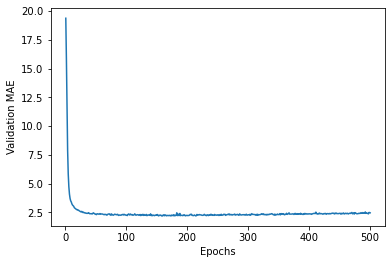

In [74]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

첫 10개의 에포크의 성능이 매우 나쁘기에 그 부분을 제외하고 그래프를 그리면 보다 정확하게 
변환 과정을 파악할 수 있다.

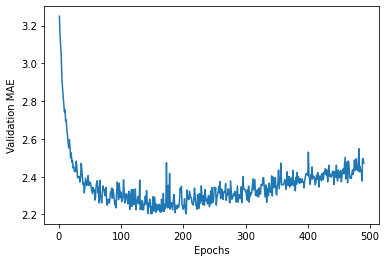

In [75]:
truncated_mae_history = average_mae_history[10:]

plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**재훈련**

- 130번 째 에포크를 전후로 과대적합 발생함.
- 130번의 에포크만 사용해서 모델 재훈련

In [76]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)

재훈련된 모델의 테스트셋에 대한 성능을 평가하면 
주택가격 예측에 있어서 평균적으로 2,500달러 정도의 차이를 갖는다.

In [77]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 0s/step - loss: 15.9659 - mae: 2.5950


2.5949742794036865

### 모델 활용

- 새로운 데이터에 대한 예측은 `predict()` 메서드를 활용한다. 

In [78]:
predictions = model.predict(test_data)
predictions[0]

array([8.091597], dtype=float32)

### 연습문제

사이킷런의 `KFold`를 이용하면 봅다 간단하게 K-겹 교차검증을 진행할 수 있다.

In [79]:
from sklearn.model_selection import KFold

k = 4
num_epochs = 500

kf = KFold(n_splits=k)
all_mae_histories = []

for train_index, val_index in kf.split(train_data, train_targets):
    
    val_data, val_targets = train_data[val_index], train_targets[val_index]
    partial_train_data, partial_train_targets = train_data[train_index], train_targets[train_index]
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history["val_mae"]    
    all_mae_histories.append(mae_history)

In [80]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 0s/step - loss: 15.7864 - mae: 2.7254


2.725350856781006

## 연습문제

1. 영화 후기 이진 분류
    1. 두 개의 은닉층 대신 1 개 또는 3 개의 은닉층을 사용할 때 
        검증셋와 테스트셋에 대한 평가지표의 변화를 확인하라.
    1. 각 은닉층에 사용된 유닛의 수를 8, 32, 64 등으로 변화시킨 후 
        검증셋과 테스트셋에 대한 평가지표의 변화를 확인하라.
    1. `binary_crossentropy` 대신 `mse`를 손실함수로 지정한 후 
        검증셋과 테스트셋에 대한 평가지표의 변화를 확인하라.
    1. `relu()` 함수 대신 이전에 많이 사용됐었던 `tanh()` 함수를 손실함수로 지정한 후 
        검증셋과 테스트셋에 대한 평가지표의 변화를 확인하라.
1. 뉴스 기사 다중 클래스 분류
    1. 아래 모델을 사용하염 정보 병목현상이 발생함을 성능 테스트를 통해 보여라.
        ```python
        model = keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(4, activation="relu"),
            layers.Dense(46, activation="softmax")
        ])
        ```
    1. 은닉층의 유닛의 수를 32, 128 등 여러 값으로 실험해 보아라.
    1. 은닉층의 수를 1개 또는 3개로 바꿔 보아라.